<a href="https://colab.research.google.com/github/YaraMansour1985/Metabolic-Syndrome-Prediction/blob/main/deep_learn_project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount drive on google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#load data
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/AXSOSACADEMY/05-IntermediateML/Week17/Data/Metabolic  Syndrome.csv')
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


In [3]:
#identify inconsistencies and addressing them, obtain value_counts in string columns
#identify string column
string_columns = df.select_dtypes(include=['object']).columns
print(string_columns)

for col in string_columns:
    print(f"Value Counts for {col}")
    print(df[col].value_counts())
    print("\n")

Index(['Sex', 'Marital', 'Race', 'MetabolicSyndrome'], dtype='object')
Value Counts for Sex
Sex
Female    1211
Male      1190
Name: count, dtype: int64


Value Counts for Marital
Marital
Married      1192
Single        498
Divorced      242
Widowed       166
Separated      95
Name: count, dtype: int64


Value Counts for Race
Race
White          933
Black          548
Asian          349
Hispanic       257
MexAmerican    253
Other           61
Name: count, dtype: int64


Value Counts for MetabolicSyndrome
MetabolicSyndrome
No MetSyn    1579
MetSyn        822
Name: count, dtype: int64




In [4]:
#drop column seqn
df=df.drop('seqn',axis=1)

In [5]:
#define numeric and categorical features
numeric_features=['Age','WaistCirc','BMI','Albuminuria','UrAlbCr','UricAcid','BloodGlucose','HDL','Triglycerides','Income']
nominal_features=['Sex','Marital','Race']

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

#Sci-kit Learn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [7]:
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [8]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred_proba = model.predict(X_train)
  # Convert probabilities to binary predictions
  y_train_pred = (y_train_pred_proba > 0.5).astype(int)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred_proba = model.predict(X_test)
  # Convert probabilities to binary predictions
  y_test_pred = (y_test_pred_proba > 0.5).astype(int)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict


In [9]:
#define x and y ,
target = "MetabolicSyndrome"
X = df.drop(columns=target)
y = df[target]

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train.head()

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
263,46,Female,Married,8200.0,White,124.0,40.8,0,18.47,3.3,140,53,198
2073,34,Male,Separated,3500.0,MexAmerican,86.2,24.5,0,16.14,6.1,114,83,60
632,33,Female,Married,3500.0,MexAmerican,75.0,25.0,0,11.54,3.4,97,44,60
1732,49,Female,Married,9000.0,Hispanic,95.7,33.3,0,3.81,2.7,89,51,139
765,30,Male,Married,9000.0,Asian,75.7,21.9,0,7.76,7.1,81,58,394


In [10]:
df['MetabolicSyndrome'].value_counts()

,count
MetabolicSyndrome,
No MetSyn,1579
MetSyn,822


In [11]:
# Imports needed for preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

# numeric_features and nominal_features are available in kernel state.
# X_train and X_test are already DataFrames from a previous split, but contain NaNs.

# Preprocessing pipeline for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Impute NaNs with median for numerical features
    ('scaler', StandardScaler()) # Scale numerical features
])

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute NaNs with most frequent for categorical features
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

# Create a preprocessor using ColumnTransformer with both numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, nominal_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Preprocess data first to handle NaNs and transform features
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Before SMOTE:", y_train.value_counts())

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

print("After SMOTE:", y_resampled.value_counts())


Before SMOTE: MetabolicSyndrome
No MetSyn    1182
MetSyn        618
Name: count, dtype: int64
After SMOTE: MetabolicSyndrome
MetSyn       1182
No MetSyn    1182
Name: count, dtype: int64


In [12]:
# define input shape
input_shape = X_resampled.shape[1]
input_shape

23

In [13]:
# Build binary classification model within function
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras import metrics # Import metrics

def build_model():
    # Instantiate Model
    model = Sequential()

    # create and compile the model with one hidden layer
    model.add(Dense(100, input_dim=input_shape, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer = 'adam', loss = 'bce', metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [14]:
# Call our build function to build model
clf_model = build_model()

# Get model summary
clf_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,501 (9.77 KB)

 Trainable params: 2,501 (9.77 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# train the model and save the history , use early stop with patience =5 monitoring val_accuracy

# Convert y_resampled to numerical labels (0 and 1)
label_mapping = {'No MetSyn': 0, 'MetSyn': 1}
y_resampled_numeric = y_resampled.map(label_mapping)
# Also convert y_test for future evaluation consistency
y_test_numeric = y_test.map(label_mapping)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
history = clf_model.fit(X_resampled, y_resampled_numeric,
          validation_split=.2,
          epochs = 50,
          callbacks=[early_stop])

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8957 - loss: 0.2395 - precision: 0.8601 - recall: 0.8649 - val_accuracy: 0.9197 - val_loss: 0.2440 - val_precision: 1.0000 - val_recall: 0.9197
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8897 - loss: 0.2492 - precision: 0.8522 - recall: 0.8671 - val_accuracy: 0.9049 - val_loss: 0.2597 - val_precision: 1.0000 - val_recall: 0.9049
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8928 - loss: 0.2431 - precision: 0.8664 - recall: 0.8571 - val_accuracy: 0.8858 - val_loss: 0.2833 - val_precision: 1.0000 - val_recall: 0.8858
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9001 - loss: 0.2325 - precision: 0.8616 - recall: 0.8504 - val_accuracy: 0.9218 - val_loss: 0.2380 - val_precision: 1.0000 - val_recall: 0.9218
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8984 - loss: 0.2413 - precision: 0.8497 - recall: 0.8611 - val_accuracy: 0.9345 - val_loss: 0.2154 - val

(<Figure size 600x1200 with 4 Axes>,
 array([<Axes: title={'center': 'accuracy'}>,
        <Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'precision'}>,
        <Axes: title={'center': 'recall'}>], dtype=object))

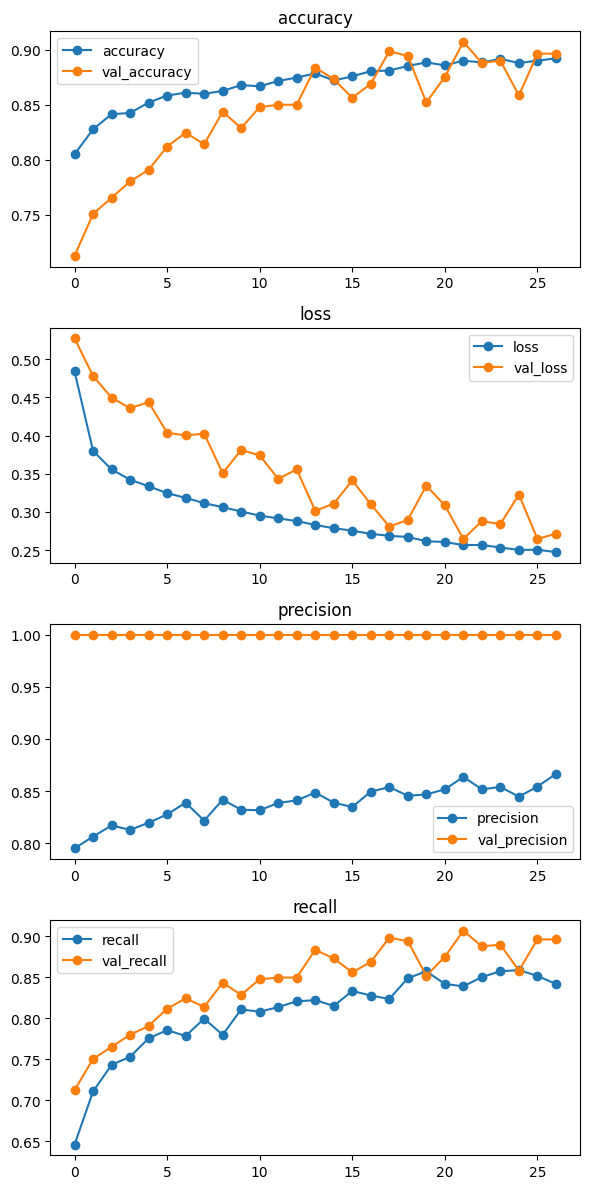

In [16]:
#plot history
plot_history(history)

Accuracy Plot:

 Both training accuracy and validation accuracy generally increase over epochs. The validation accuracy closely follows the training accuracy, suggesting the model is learning effectively and generalizing well to unseen data. This indicates good learning progress without significant overfitting in terms of overall correct predictions.

Loss Plot:

 Both training loss and validation loss decrease over time. The validation loss remains close to the training loss, which is a positive sign that the model is not overfitting drastically. A continuously decreasing validation loss suggests the model is still finding better ways to fit the data.

Precision Plot:

The precision for both training and validation also shows an upward trend. High precision means that when the model predicts 'MetSyn', it is often correct.

Recall Plot:

Similarly, the recall for both sets increases. High recall means the model is good at identifying all actual 'MetSyn' cases.

Overall, the plots indicate that clf_model is learning well, and the early stopping mechanism likely helped to prevent significant overfitting by stopping training when validation accuracy improvements plateaued. The model shows consistent improvement across all metrics on both training and validation sets.



74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1182
           1       0.91      0.91      0.91      1182

    accuracy                           0.91      2364
   macro avg       0.91      0.91      0.91      2364
weighted avg       0.91      0.91      0.91      2364



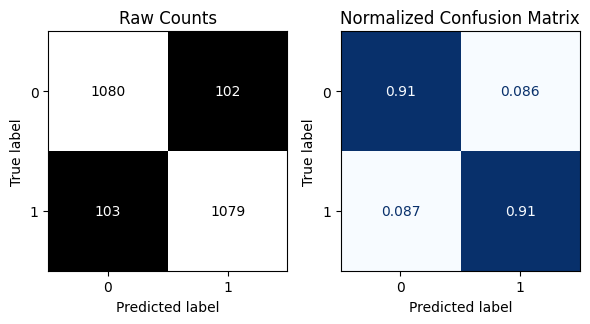


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       397
           1       0.77      0.80      0.78       204

    accuracy                           0.85       601
   macro avg       0.83      0.84      0.83       601
weighted avg       0.85      0.85      0.85       601



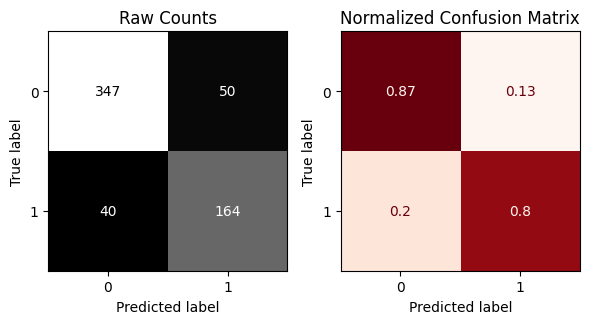

In [24]:
#evaluate model
evaluate_classification(clf_model, X_resampled, y_resampled_numeric, X_test_processed, y_test_numeric)

Summary:

The model performs very well on the training data across all metrics. On the test data, the overall accuracy is slightly lower (0.84 vs 0.90), which is expected as the model has not seen this data before. There's a noticeable drop in precision and recall for the 'MetSyn' class (Class 1) on the test set compared to the training set (0.77 precision, 0.76 recall vs. 0.92 precision, 0.88 recall). This suggests that while the model generalizes well for the 'No MetSyn' class, its ability to correctly identify and predict 'MetSyn' cases on unseen data is somewhat diminished. This could indicate a slight overfitting to the training data for the 'MetSyn' class, or that the 'MetSyn' class is inherently harder to predict accurately on new data

In [18]:
#build another model by tuning , use dropout and optimizer
def build_model():
    # Instantiate Model
    model2 = Sequential()

    # create and compile the model with more hidden layers more neurons and dropout

    # create and compile the model
    model2.add(Dense(100, input_dim=input_shape, activation = 'relu'))
    model2.add(Dropout(0.3)) # Added Dropout layer
    model2.add(Dense(50, activation = 'relu'))
    model2.add(Dropout(0.3)) # Added another Dropout layer
    model2.add(Dense(1, activation = 'sigmoid'))

    model2.compile(optimizer = 'adam', loss = 'bce', metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model2

In [19]:
# Call our build function to build model
clf_model2 = build_model()

# Get model summary
clf_model2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 100)            │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,501 (29.30 KB)

 Trainable params: 7,501 (29.30 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# train the model and save the history , use early stop with patience =5 monitoring val_accuracy

# Convert y_resampled to numerical labels (0 and 1)
label_mapping = {'No MetSyn': 0, 'MetSyn': 1}
y_resampled_numeric = y_resampled.map(label_mapping)
# Also convert y_test for future evaluation consistency
y_test_numeric = y_test.map(label_mapping)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
history = clf_model2.fit(X_resampled, y_resampled_numeric,
          validation_split=.2,
          epochs = 50,
          callbacks=[early_stop])

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6646 - loss: 0.5967 - precision_1: 0.5879 - recall_1: 0.4170 - val_accuracy: 0.6913 - val_loss: 0.5917 - val_precision_1: 1.0000 - val_recall_1: 0.6913
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8384 - loss: 0.3722 - precision_1: 0.8128 - recall_1: 0.7228 - val_accuracy: 0.7442 - val_loss: 0.4851 - val_precision_1: 1.0000 - val_recall_1: 0.7442
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8158 - loss: 0.3973 - precision_1: 0.7706 - recall_1: 0.7273 - val_accuracy: 0.7865 - val_loss: 0.4358 - val_precision_1: 1.0000 - val_recall_1: 0.7865
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8286 - loss: 0.3749 - precision_1: 0.7736 - recall_1: 0.7744 - val_accuracy: 0.7970 - val_loss: 0.4408 - val_precision_1: 1.0000 - val_recall_1: 0.7970
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8341 - loss: 0.3642 - precision_1: 0.7925 - recall_1: 0.7367 - val_accur

(<Figure size 600x1200 with 4 Axes>,
 array([<Axes: title={'center': 'accuracy'}>,
        <Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'precision_1'}>,
        <Axes: title={'center': 'recall_1'}>], dtype=object))

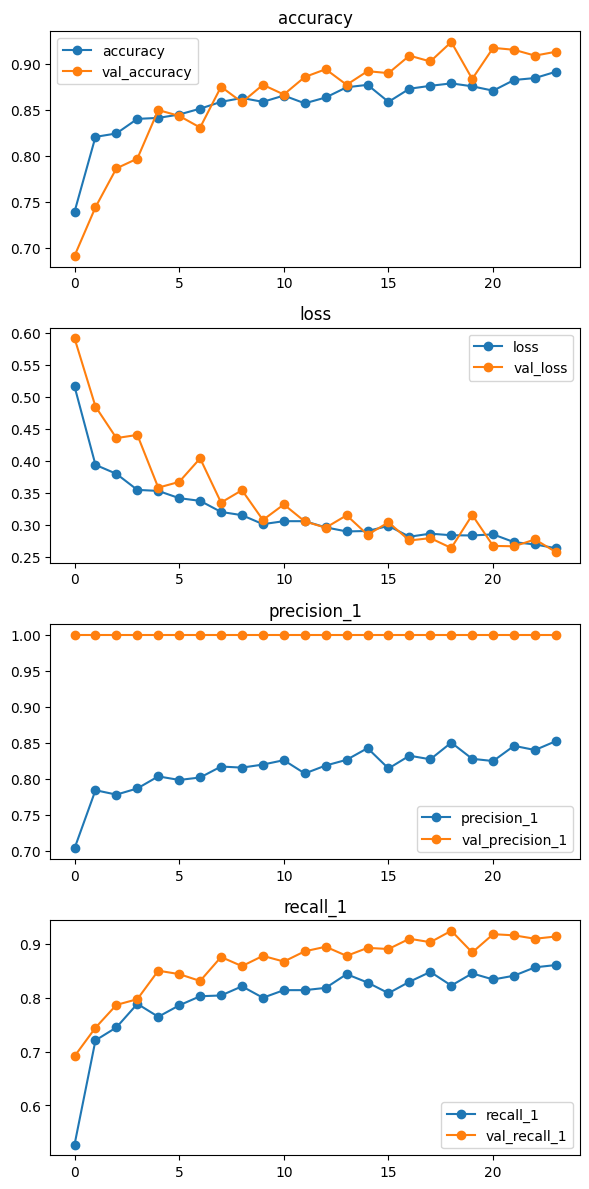

In [21]:
#plot history
plot_history(history)

 The plots suggest that clf_model2 is struggling significantly to learn from the training data. The consistently lower training metrics compared to validation metrics (especially accuracy and loss) indicate a clear case of underfitting on the training set, or that the regularization is too aggressive, preventing the model from grasping the underlying patterns.

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1182
           1       0.92      0.89      0.90      1182

    accuracy                           0.90      2364
   macro avg       0.90      0.90      0.90      2364
weighted avg       0.90      0.90      0.90      2364



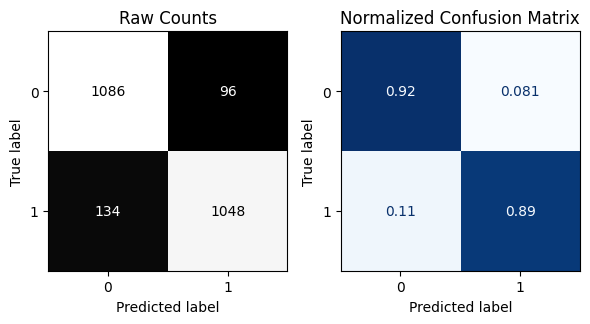


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       397
           1       0.79      0.76      0.78       204

    accuracy                           0.85       601
   macro avg       0.83      0.83      0.83       601
weighted avg       0.85      0.85      0.85       601



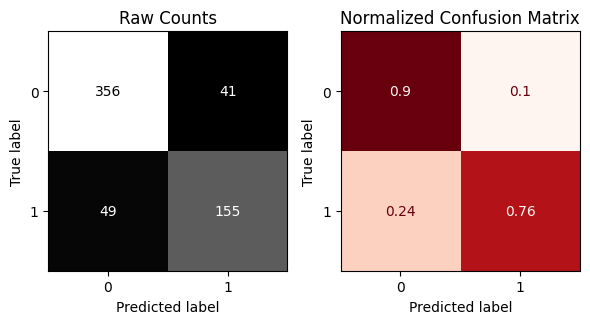

In [22]:
#evaluate model
evaluate_classification(clf_model2, X_resampled, y_resampled_numeric, X_test_processed, y_test_numeric)

This model is severely underfitting. The performance on the training data is extremely poor, especially for the 'MetSyn' class (Class 1), where it correctly identifies only 10% of actual positive cases. While accuracy on the test set is slightly higher than on the training set (which is unusual), the overall performance is very weak. The aggressive dropout layers (0.3 on two layers) that were added, combined with potentially too few neurons or layers for the complexity of the problem, are likely causing the model to be too simple or too regularized to capture the patterns in the data. This model is not effective for classification.

